# Import Modules & Util Functions

In [1]:
import os
import sys
import glob
import re
import ast
import warnings
import time

import csv
import json
import pickle

import math
import random
import numpy as np
import scipy as sp
import datetime as dt
import pandas as pd
import swifter
from scipy.stats import gaussian_kde
from scipy.integrate import quad
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

import portion as P
import itertools as it
import copy
from tqdm.notebook import tqdm
from collections import namedtuple
from pprint import pprint
from pytictoc import TicToc

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from my_utils import *

# Configure display options
# pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
%config InlineBackend.figure_format = 'retina'

# Set plot style
# plt.style.use('ggplot')


# Dual Radio Evaluation

In [6]:
class DEval:
    def __init__(self, filepaths, model_name='Test', model_suffix=None, sr_model_id=None, dr_model_id=None, load_path='.', save_path='.',
                 sp_columns=['type'], ts_column='Timestamp',
                 metrics=['dl_lost']):
        # Initialize instance variables
        self.filepaths = copy.deepcopy(filepaths)
        
        if sr_model_id is None:
            raise TypeError("請輸入SR模型編號")
        else:
            self.sr_model_id = sr_model_id
        
        if dr_model_id is None:
            raise TypeError("請輸入DR模型編號")
        else:
            self.dr_model_id = dr_model_id
        
        self.model_name = model_name
        self.save_path = save_path
        
        self.load_path = os.path.join(load_path, self.sr_model_id, 'models', self.model_name)
        print(self.load_path)
        with open(f'{self.load_path}_kde_models.pkl', 'rb') as f:
            self.kde_models = pickle.load(f)
        with open(f'{self.load_path}_hist_models.pkl', 'rb') as f:
            self.hist_models = pickle.load(f)
        with open(f'{self.load_path}_scope_models.pkl', 'rb') as f:
            self.scope_models = pickle.load(f)
        with open(f'{self.load_path}_plr_models.pkl', 'rb') as f:
            self.plr_models = pickle.load(f)
        with open(f'{self.load_path}_sr_prob_models.pkl', 'rb') as f:
            self.sr_prob_models = pickle.load(f)
            
        self.load_path = os.path.join(load_path, self.sr_model_id, self.dr_model_id, self.model_name)
        print(self.load_path)
        if model_suffix is None:
            print(f'{self.load_path}_dr_prob_models.pkl')
            with open(f'{self.load_path}_dr_prob_models.pkl', 'rb') as f:
                self.dr_prob_models = pickle.load(f)
        else:
            print(f'{self.load_path}_dr_prob_models_{model_suffix}.pkl')
            with open(f'{self.load_path}_dr_prob_models_{model_suffix}.pkl', 'rb') as f:
                self.dr_prob_models = pickle.load(f)
        self.model_suffix = model_suffix
        
        self.sp_columns = sp_columns[:]
        self.ts_column = ts_column
        self.metrics = metrics[:]
        
        _, _, _, self.figure_id = figure_identity()
        
        # Sample data
        self.LOSS_GT = []
        self.LOSS_EV = []
        self.LOSS_STD = []
        self.DEVICES = []
        self.TRACES = []
        
        # all records
        self.records = []

    @staticmethod
    def generate_random_boolean(probability_true):
        return random.random() < probability_true
    
    @staticmethod
    def interpolate(x, y, ratio=0.5):
        """
        Args:
            x, y (datetime.datetime): x < y
            ratio (float): a decimal numeral in a range [0, 1]; 0 means break at x, 1 means break at y.
        Returns:
            (datetime.datetime): breakpoint of interpolation
        """
        return x + (y - x) * ratio
    
    def hist_method(self, df, ho_df, mode_mets, mets, RATE_TYPE):
        scope = self.scope_models[mode_mets]
        hist_model = self.hist_models[mode_mets]
        prob_model = self.sr_prob_models[mode_mets]
        plr_model = self.plr_models[mode_mets]
        
        this_df = df.copy()
        for i, row in ho_df.iterrows():
            prior_row = ho_df.iloc[i-1] if i != 0 else None
            post_row = ho_df.iloc[i+1] if i != len(ho_df) - 1 else None

            # Peek the next event to avoid HO overlapping with handoverFailure (skip!!)
            if i != len(ho_df) - 1 and pd.notna(row.end) and row.end > post_row.start:
                # print('Overlapping event occurs!!')
                # print(i, row['start'], row['end'], row['type'], row['cause'])
                # print(i+1, post_row['start'], post_row['end'], post_row['type'], post_row['cause'])
                continue
            
            # Set prior event if the prior loop is skipped
            if i != 0 and pd.notna(prior_row.end) and prior_row.end > row.start:
                prior_row = ho_df.iloc[i-2] if i > 1 else None
            
            # Basic information of the current row
            tag = '_'.join([s for s in row[self.sp_columns] if pd.notna(s)])  # specific column name
            start_ts, end_ts = row['start'], row['end']  # handover start/end time
            interruption_time = (end_ts - start_ts).total_seconds() if pd.notna(end_ts) else 0  # handover interruption time
            
            # Set simple left/right bounds
            current_left_bound = start_ts + pd.Timedelta(seconds=(scope[tag][0]))
            current_right_bound = start_ts + pd.Timedelta(seconds=(scope[tag][1]))
            
            # Set left/right bounds to avoid event overlapping with each other
            if prior_row is not None:
                prior_tag = '_'.join([s for s in prior_row[self.sp_columns] if pd.notna(s)])
                prior_right_bound = prior_row['start'] + pd.Timedelta(seconds=(scope[prior_tag][1]))
                if pd.notna(prior_row['end']):
                    left_bound = min(max(current_left_bound, DEval.interpolate(prior_right_bound, current_left_bound), prior_row['end']), start_ts)
                else:
                    left_bound = min(max(current_left_bound, DEval.interpolate(prior_right_bound, current_left_bound), prior_row['start']), start_ts)
            else:
                left_bound = current_left_bound
            
            if post_row is not None:
                post_tag = '_'.join([s for s in post_row[self.sp_columns] if pd.notna(s)])
                post_left_bound = post_row['start'] + pd.Timedelta(seconds=(scope[post_tag][0]))
                if pd.notna(end_ts):
                    right_bound = max(min(current_right_bound, DEval.interpolate(current_right_bound, post_left_bound), post_row['start']), end_ts)
                else:
                    right_bound = max(min(current_right_bound, DEval.interpolate(current_right_bound, post_left_bound), post_row['start']), start_ts)
            else:
                right_bound = current_right_bound
            
            interval = P.closed(left_bound, right_bound)
            
            # Concatenate PLR from mapping list
            current_df = this_df[this_df['Timestamp'] < interval.upper].copy()
            plr_mapping = hist_model[tag].copy()
            
            current_df[f'relative_time'] = (current_df['Timestamp'] - start_ts).dt.total_seconds()
            current_df[f'window_id'] = ((current_df[f'relative_time'] + 0.005) // 0.01) * 0.01
            
            trigger_probability = prob_model[tag]
            
            if plr_mapping.empty:
                tmp = current_df.copy().rename(columns={mets: f'{mets}_x'})
            else:
                tmp = pd.merge(current_df, plr_mapping, on='window_id', how='left')
                tmp[RATE_TYPE] = tmp[RATE_TYPE].fillna(0)
                
                if not DEval.generate_random_boolean(trigger_probability):
                    tmp[RATE_TYPE] = 0
            
            tmp['type'] = tag
            
            if i == 0:
                answer = tmp.copy()
            else:
                answer = pd.concat([answer, tmp], axis=0)
            
            # Update dataframe to accelerate the speed
            this_df = this_df[this_df[self.ts_column] >= interval.upper].copy()
        
        answer = pd.concat([answer, this_df], axis=0)
        
        # Consider stable duration
        stable_df = answer[answer['tx_count'].isnull()].copy()[['seq', 'lost_x', 'excl', 'Timestamp']].rename(columns={'lost_x': 'lost'})

        stable_df['Timestamp_sec'] = stable_df['Timestamp'].dt.floor('S')
        stable_df['relative_time'] = (stable_df['Timestamp'] - stable_df['Timestamp_sec']).dt.total_seconds() - 0.5
        stable_df['window_id'] = ((stable_df['relative_time'] + 0.01 / 2) // 0.01) * 0.01

        plr_mapping = hist_model['Stable'].copy()        
        stable_df = pd.merge(stable_df, plr_mapping, on='window_id', how='left').rename(columns={'PLR': 'PLR_if_trigger'})
        trigger_prob_mapping = stable_df[~stable_df['Timestamp_sec'].duplicated()].reset_index(drop=True)[['Timestamp_sec']]
        
        trigger_probability = prob_model['Stable']
        random_bool_array = [DEval.generate_random_boolean(trigger_probability) for _ in range(len(trigger_prob_mapping))]
        trigger_prob_mapping['trigger'] = random_bool_array

        stable_df = pd.merge(stable_df, trigger_prob_mapping, on='Timestamp_sec', how='left')
        stable_df['PLR'] = stable_df['PLR_if_trigger'] * stable_df['trigger']
        
        stable_df['type'] = 'Stable'

        del stable_df['Timestamp_sec'], stable_df['PLR_if_trigger'], stable_df['trigger']
        
        answer = answer[answer['tx_count'].notnull()].copy()
        
        answer = pd.concat([answer, stable_df], axis=0)
        answer = answer.sort_values(by='Timestamp').reset_index(drop=True)
        answer['PLR'] = answer['PLR'] / 100
        answer['Y'] = answer['PLR'].apply(DEval.generate_random_boolean)
        
        eval_value = answer['Y'].mean() * 100
        ground_value = df['lost'].mean() * 100
        
        answer = pd.concat([answer[['seq', 'Timestamp', 'type', 'relative_time', 'window_id']],
                            df[['lost']],
                            answer[[RATE_TYPE, 'Y']]], axis=1)
        
        return answer, eval_value, ground_value
    
    
    def setup_profile(self, df, ho_df, df2, scope):
        
        this_df = df2.copy()
        this_df = this_df[this_df['Y']].copy().reset_index(drop=True)
        
        df['anchor_type'] = 'Stable'
        df['anchor_state'] = 0
        for i, row in ho_df.iterrows():
            prior_row = ho_df.iloc[i-1] if i != 0 else None
            post_row = ho_df.iloc[i+1] if i != len(ho_df) - 1 else None

            # Peek the next event to avoid HO overlapping with handoverFailure (skip!!)
            if i != len(ho_df) - 1 and pd.notna(row.end) and row.end > post_row.start:
                # print('Overlapping event occurs!!')
                # print(i, row['start'], row['end'], row['type'], row['cause'])
                # print(i+1, post_row['start'], post_row['end'], post_row['type'], post_row['cause'])
                continue
            
            # Set prior event if the prior loop is skipped
            if i != 0 and pd.notna(prior_row.end) and prior_row.end > row.start:
                prior_row = ho_df.iloc[i-2] if i > 1 else None
            
            # Basic information of the current row
            tag = '_'.join([s for s in row[self.sp_columns] if pd.notna(s)])  # specific column name
            start_ts, end_ts = row['start'], row['end']  # handover start/end time
            interruption_time = (end_ts - start_ts).total_seconds() if pd.notna(end_ts) else 0  # handover interruption time
            
            # Set simple left/right bounds
            current_left_bound = start_ts + pd.Timedelta(seconds=(scope[tag][0]))
            current_right_bound = start_ts + pd.Timedelta(seconds=(scope[tag][1]))
            
            # Set left/right bounds to avoid event overlapping with each other
            if prior_row is not None:
                prior_tag = '_'.join([s for s in prior_row[self.sp_columns] if pd.notna(s)])
                prior_right_bound = prior_row['start'] + pd.Timedelta(seconds=(scope[prior_tag][1]))
                if pd.notna(prior_row['end']):
                    left_bound = min(max(current_left_bound, DEval.interpolate(prior_right_bound, current_left_bound), prior_row['end']), start_ts)
                else:
                    left_bound = min(max(current_left_bound, DEval.interpolate(prior_right_bound, current_left_bound), prior_row['start']), start_ts)
            else:
                left_bound = current_left_bound
            
            if post_row is not None:
                post_tag = '_'.join([s for s in post_row[self.sp_columns] if pd.notna(s)])
                post_left_bound = post_row['start'] + pd.Timedelta(seconds=(scope[post_tag][0]))
                if pd.notna(end_ts):
                    right_bound = max(min(current_right_bound, DEval.interpolate(current_right_bound, post_left_bound), post_row['start']), end_ts)
                else:
                    right_bound = max(min(current_right_bound, DEval.interpolate(current_right_bound, post_left_bound), post_row['start']), start_ts)
            else:
                right_bound = current_right_bound
            
            interval = P.closed(left_bound, right_bound)
            
            df.loc[(df['start'] >= interval.lower) & (df['start'] < interval.upper), 'anchor_type'] = tag
            
            if not this_df[(this_df['Timestamp'] >= interval.lower) & (this_df['Timestamp'] < interval.upper)].empty:
                df.loc[(df['start'] >= interval.lower) & (df['start'] < interval.upper), 'anchor_state'] = 1
                
            # Update dataframe to accelerate the speed
            this_df = this_df[this_df[self.ts_column] >= interval.upper].copy()
            
        return df
    
    
    def hist_method_dual(self, df, ho_df, mode_mets, mets, RATE_TYPE):
        scope = self.scope_models[mode_mets]
        hist_model = self.hist_models[mode_mets]
        dr_prob_model = self.dr_prob_models[mode_mets]
        
        this_df = df.copy()
        for i, row in ho_df.iterrows():
            prior_row = ho_df.iloc[i-1] if i != 0 else None
            post_row = ho_df.iloc[i+1] if i != len(ho_df) - 1 else None

            # Peek the next event to avoid HO overlapping with handoverFailure (skip!!)
            if i != len(ho_df) - 1 and pd.notna(row.end) and row.end > post_row.start:
                # print('Overlapping event occurs!!')
                # print(i, row['start'], row['end'], row['type'], row['cause'])
                # print(i+1, post_row['start'], post_row['end'], post_row['type'], post_row['cause'])
                continue
            
            # Set prior event if the prior loop is skipped
            if i != 0 and pd.notna(prior_row.end) and prior_row.end > row.start:
                prior_row = ho_df.iloc[i-2] if i > 1 else None
            
            # Basic information of the current row
            tag = '_'.join([s for s in row[self.sp_columns] if pd.notna(s)])  # specific column name
            start_ts, end_ts = row['start'], row['end']  # handover start/end time
            interruption_time = (end_ts - start_ts).total_seconds() if pd.notna(end_ts) else 0  # handover interruption time
            
            # Set simple left/right bounds
            current_left_bound = start_ts + pd.Timedelta(seconds=(scope[tag][0]))
            current_right_bound = start_ts + pd.Timedelta(seconds=(scope[tag][1]))
            
            # Set left/right bounds to avoid event overlapping with each other
            if prior_row is not None:
                prior_tag = '_'.join([s for s in prior_row[self.sp_columns] if pd.notna(s)])
                prior_right_bound = prior_row['start'] + pd.Timedelta(seconds=(scope[prior_tag][1]))
                if pd.notna(prior_row['end']):
                    left_bound = min(max(current_left_bound, DEval.interpolate(prior_right_bound, current_left_bound), prior_row['end']), start_ts)
                else:
                    left_bound = min(max(current_left_bound, DEval.interpolate(prior_right_bound, current_left_bound), prior_row['start']), start_ts)
            else:
                left_bound = current_left_bound
            
            if post_row is not None:
                post_tag = '_'.join([s for s in post_row[self.sp_columns] if pd.notna(s)])
                post_left_bound = post_row['start'] + pd.Timedelta(seconds=(scope[post_tag][0]))
                if pd.notna(end_ts):
                    right_bound = max(min(current_right_bound, DEval.interpolate(current_right_bound, post_left_bound), post_row['start']), end_ts)
                else:
                    right_bound = max(min(current_right_bound, DEval.interpolate(current_right_bound, post_left_bound), post_row['start']), start_ts)
            else:
                right_bound = current_right_bound
            
            interval = P.closed(left_bound, right_bound)
            
            # Concatenate PLR from mapping list
            current_df = this_df[this_df['Timestamp'] < interval.upper].copy()
            plr_mapping = hist_model[tag].copy()
            
            current_df[f'relative_time'] = (current_df['Timestamp'] - start_ts).dt.total_seconds()
            current_df[f'window_id'] = ((current_df[f'relative_time'] + 0.005) // 0.01) * 0.01
            
            anchor_tag = row['anchor_type']
            anchor_state = row['anchor_state']
            
            if anchor_state == 1:
                trigger_probability = dr_prob_model[(anchor_tag, tag)][0]
            else:
                trigger_probability = dr_prob_model[(anchor_tag, tag)][1]
            
            if plr_mapping.empty:
                tmp = current_df.copy().rename(columns={mets: f'{mets}_x'})
            else:
                tmp = pd.merge(current_df, plr_mapping, on='window_id', how='left')
                tmp[RATE_TYPE] = tmp[RATE_TYPE].fillna(0)
                
                if not DEval.generate_random_boolean(trigger_probability):
                    tmp[RATE_TYPE] = 0
            
            tmp['anchor_type'] = anchor_tag
            tmp['anchor_state'] = anchor_state
            tmp['type'] = tag
            
            if i == 0:
                answer = tmp.copy()
            else:
                answer = pd.concat([answer, tmp], axis=0)
            
            # Update dataframe to accelerate the speed
            this_df = this_df[this_df[self.ts_column] >= interval.upper].copy()
        
        answer = pd.concat([answer, this_df], axis=0)
        # display(answer)
        
        # Consider stable duration
        stable_df = answer[answer['tx_count'].isnull()].copy()[['seq', 'lost_x', 'excl', 'Timestamp']].rename(columns={'lost_x': 'lost'})

        stable_df['Timestamp_sec'] = stable_df['Timestamp'].dt.floor('S')
        stable_df['relative_time'] = (stable_df['Timestamp'] - stable_df['Timestamp_sec']).dt.total_seconds() - 0.5
        stable_df['window_id'] = ((stable_df['relative_time'] + 0.01 / 2) // 0.01) * 0.01

        plr_mapping = hist_model['Stable'].copy()        
        stable_df = pd.merge(stable_df, plr_mapping, on='window_id', how='left').rename(columns={'PLR': 'PLR_if_trigger'})
        trigger_prob_mapping = stable_df[~stable_df['Timestamp_sec'].duplicated()].reset_index(drop=True)[['Timestamp_sec']]
        
        trigger_probability = dr_prob_model[('Stable', 'Stable')][0]
        
        # if anchor_state == 1:
        #     trigger_probability = dr_prob_model[(anchor_tag, tag)][0]
        # else:
        #     trigger_probability = dr_prob_model[(anchor_tag, tag)][1]
                
        random_bool_array = [DEval.generate_random_boolean(trigger_probability) for _ in range(len(trigger_prob_mapping))]
        trigger_prob_mapping['trigger'] = random_bool_array

        stable_df = pd.merge(stable_df, trigger_prob_mapping, on='Timestamp_sec', how='left')
        stable_df['PLR'] = stable_df['PLR_if_trigger'] * stable_df['trigger']
        
        # stable_df['type'] = 'Stable'
        stable_df['anchor_type'] = 'Stable'
        stable_df['anchor_state'] = 0
        stable_df['type'] = 'Stable'

        del stable_df['Timestamp_sec'], stable_df['PLR_if_trigger'], stable_df['trigger']
        
        answer = answer[answer['tx_count'].notnull()].copy()
        
        answer = pd.concat([answer, stable_df], axis=0)
        answer = answer.sort_values(by='Timestamp').reset_index(drop=True)
        answer['PLR'] = answer['PLR'] / 100
        answer['Y'] = answer['PLR'].apply(DEval.generate_random_boolean)
        
        eval_value = answer['Y'].mean() * 100
        ground_value = df['lost'].mean() * 100
        
        answer = pd.concat([answer[['seq', 'Timestamp', 'anchor_type', 'anchor_state', 'type', 'relative_time', 'window_id']],
                            df[['lost']],
                            answer[[RATE_TYPE, 'Y']]], axis=1)

        return answer, eval_value, ground_value

        # return answer, eval_value, ground_value
        
        # # Consider stable duration
        # stable_df = answer[answer['tx_count'].isnull()].copy()[['seq', 'lost_x', 'excl', 'Timestamp']].rename(columns={'lost_x': 'lost'})

        # stable_df['Timestamp_sec'] = stable_df['Timestamp'].dt.floor('S')
        # stable_df['relative_time'] = (stable_df['Timestamp'] - stable_df['Timestamp_sec']).dt.total_seconds() - 0.5
        # stable_df['window_id'] = ((stable_df['relative_time'] + 0.01 / 2) // 0.01) * 0.01

        # plr_mapping = hist_model['Stable'].copy()
        # stable_df = pd.merge(stable_df, plr_mapping, on='window_id', how='left').rename(columns={'PLR': 'PLR_trig'})

        # trig_p_mapping = stable_df[~stable_df['Timestamp_sec'].duplicated()].reset_index(drop=True)
        
        # triggered_p = dr_prob_model[('Stable', 'Stable')][0]
        
        # random_bool_array = [DEval.generate_random_boolean(triggered_p) for _ in range(len(trig_p_mapping))]
        # trig_p_mapping['trigger'] = random_bool_array
        # trig_p_mapping = trig_p_mapping[['Timestamp_sec', 'trigger']]

        # stable_df = pd.merge(stable_df, trig_p_mapping, on='Timestamp_sec', how='left')
        # stable_df['PLR'] = stable_df['PLR_trig'] * stable_df['trigger']

        # del stable_df['Timestamp_sec'], stable_df['PLR_trig'], stable_df['trigger']
        
        # answer = answer[answer['tx_count'].notnull()].copy()
        # # display(answer)
        
        # answer = pd.concat([answer, stable_df], axis=0)
        # answer = answer.sort_values(by='Timestamp').reset_index(drop=True)
        # answer['PLR'] = answer['PLR'] / 100
        # answer['Y'] = answer['PLR'].apply(DEval.generate_random_boolean)
        
        # eval_value = answer['Y'].mean() * 100
        # ground_value = df['lost'].mean() * 100
    
    
    def run_hist_method(self, N=3):
        scope = self.scope_models['dl_lost']
        n = len(self.filepaths)
        for mode_mets in ['dl_lost']:
            for i, filepath in enumerate(self.filepaths):
                
                # if i > 35:
                #     break
                
                # if i > 0:
                #     break
                
                print(f'{i}/{n}', filepath[0][0]); print(f'{i}/{n}', filepath[0][1]); print(f'{i}/{n}', filepath[0][2])
                print(f'{i}/{n}', filepath[1][0]); print(f'{i}/{n}', filepath[1][1]); print(f'{i}/{n}', filepath[1][2])
                    
                ho_df1 = pd.read_csv(filepath[0][0], parse_dates=['start', 'end'])
                ho_df2 = pd.read_csv(filepath[1][0], parse_dates=['start', 'end'])
                
                if ho_df1.empty or ho_df2.empty:
                    print('******** Empty RRC Data ********')
                    continue
                
                # df, ho_df, empty_data = data_aligner(df, ho_df)
                
                df1 = pd.read_csv(filepath[0][1], parse_dates=['Timestamp'])[['seq', 'Timestamp', 'lost', 'excl', 'latency']]
                df2 = pd.read_csv(filepath[1][1], parse_dates=['Timestamp'])[['seq', 'Timestamp', 'lost', 'excl', 'latency']]
                df1, ho_df1, empty_data1 = data_aligner(df1, ho_df1)
                df2, ho_df2, empty_data2 = data_aligner(df2, ho_df2)
                
                if empty_data1 or empty_data2:
                    print('******** Empty RRC Data ********')
                    continue
                
                df = pd.merge(df1, df2, on='seq', how='inner').reset_index(drop=True)
                
                df1 = df[['seq', 'Timestamp_x', 'lost_x', 'excl_x', 'latency_x']].rename(columns={'Timestamp_x': 'Timestamp', 'lost_x': 'lost', 'excl_x': 'excl', 'latency_x': 'latency'})
                df2 = df[['seq', 'Timestamp_y', 'lost_y', 'excl_y', 'latency_y']].rename(columns={'Timestamp_y': 'Timestamp', 'lost_y': 'lost', 'excl_y': 'excl', 'latency_y': 'latency'})
                
                loss_rate_list = []
                answer = None
                for iter_round in tqdm(range(N), ncols=1000):
                    ans1, eval_value1, ground_value1 = eval.hist_method(df1, ho_df1, mode_mets='dl_lost', mets='lost', RATE_TYPE='PLR')
                    # display(answer1)
                    
                    # setup_profile
                    # ho_df1 = self.setup_profile(ho_df1, ho_df2, df2, scope)
                    avatar_ho_df2 = self.setup_profile(ho_df2.copy(), ho_df1, ans1, scope)
                    
                    # display(avatar_ho_df2)
                    
                    ans2, eval_value2, ground_value2 = eval.hist_method_dual(df2, avatar_ho_df2, mode_mets='dl_lost', mets='lost', RATE_TYPE='PLR')
                    
                    # display(ans1)
                    # display(ans2)
                    # display(answer2)
                    
                    ans = pd.merge(ans1, ans2, on='seq', how='inner').reset_index(drop=True)
                    ans['lost'] = (ans['lost_x']) & (ans['lost_y'])
                    ans['Y'] = (ans['Y_x']) & (ans['Y_y'])
                    ans = ans[['seq', 'Timestamp_x', 'Timestamp_y', 'type_x', 'anchor_type', 'anchor_state', 'type_y', 'relative_time_x', 'window_id_x', 'relative_time_y', 'window_id_y', 'lost_x', 'lost_y', 'lost', 'PLR_x', 'Y_x', 'PLR_y', 'Y_y', 'Y']]
                    
                    # display(ans)
                    
                    handle = (ans1['Y']) & (ans2['Y'])
                    eval_value = handle.mean() * 100
                    # print('eval:', eval_value, len(handle))
                    
                    handle = (df1['lost']) & (df2['lost'])
                    ground_value = handle.mean() * 100
                    # print('ground:', ground_value, len(handle))
                    
                    if answer is None:
                        answer = ans.copy()
                        answer = answer.rename(columns={'PLR_x': f'PLR_x_0', 'Y_x': f'Y_x_0', 'PLR_y': f'PLR_y_0', 'Y_y': f'Y_y_0', 'Y': f'Y_0'})
                    else:
                        answer = pd.concat([answer, ans[['PLR_x', 'Y_x', 'PLR_y', 'Y_y', 'Y']]], axis=1)
                        answer = answer.rename(columns={'PLR_x': f'PLR_x_{iter_round}', 'Y_x': f'Y_x_{iter_round}', 'PLR_y': f'PLR_y_{iter_round}', 'Y_y': f'Y_y_{iter_round}', 'Y': f'Y_{iter_round}'})
                    
                    loss_rate_list.append(eval_value)
                
                # display(answer)
        
                mean_value = np.mean(loss_rate_list)
                std_deviation = np.std(loss_rate_list)

                # print()
                # print("Mean:", mean_value)
                # print("Standard Deviation:", std_deviation)
                # print("Ground Truth:", ground_value)
                
                self.LOSS_GT.append(ground_value)
                self.LOSS_EV.append(mean_value)
                self.LOSS_STD.append(std_deviation)
                
                path1 = filepath[0][1]
                path2 = filepath[1][1]
                
                error = mean_value - ground_value
                self.records.append((mean_value, std_deviation, ground_value, error, path1, path2))

                def find_sm_label(path):
                    # 找到 "sm" 的位置
                    sm_index = path.index("sm")
                    # 从 "sm" 的位置开始找到下一个斜杠 "/"
                    next_slash_index = path.index("/", sm_index)
                    # 截取 "sm00" 标签
                    # sm_label = path[sm_index:next_slash_index]
                    sm_label = path[sm_index+2:next_slash_index]
                    # print("截取的标签为:", sm_label)
                    return sm_label
                
                self.DEVICES.append(find_sm_label(path1)+'+'+find_sm_label(path2))
                
                def find_tr_label(path):
                    # 找到 "sm" 的位置
                    sm_index = path.index("#")
                    # 从 "sm" 的位置开始找到下一个斜杠 "/"
                    next_slash_index = path.index("/", sm_index)
                    # 截取 "sm00" 标签
                    # sm_label = path[sm_index:next_slash_index]
                    sm_label = path[sm_index+1:next_slash_index]
                    # print("截取的标签为:", sm_label)
                    return sm_label
                
                self.TRACES.append(find_tr_label(path1)+'+'+find_tr_label(path2))
                
                if self.model_suffix is None:
                    save_path = os.path.join(self.save_path, self.sr_model_id, self.dr_model_id, 'results', self.figure_id)
                else:
                    save_path = os.path.join(self.save_path, self.sr_model_id, self.dr_model_id, 'results', f'{self.figure_id}_{self.model_suffix}')
                    
                if not os.path.isdir(save_path):
                    os.makedirs(save_path)
                
                save_path = os.path.join(save_path, path1.replace('/', '\\')[:-4]+path2.replace('/', '\\'))
                print(save_path)
                answer.to_csv(save_path, index=False)
    
    
    def plot(self, save_name='plot_example', save_path='.'):
        # Sample data
        x = self.LOSS_GT.copy()
        y = self.LOSS_EV.copy()

        # Standard deviations for error bars
        y_error = self.LOSS_STD.copy()

        # Create figure and axes
        fig, ax = plt.subplots(figsize=(6, 4))

        # Scatter plot with error bars and horizontal caps
        ax.errorbar(x, y, yerr=y_error, linestyle='None', marker='o', color='tab:blue', capsize=5)
        ax.scatter([], [], linestyle='None', marker='o', color='tab:blue', label='Data Points')

        # Regression line
        coefficients = np.polyfit(x, y, 1)
        regression_line = np.poly1d(coefficients)
        ax.plot(ax.get_xlim(), regression_line(ax.get_xlim()), linestyle='--', linewidth=1.1, color='tab:blue', label='Regression Line')

        # Annotate the slope of the regression line
        # slope_annotation = f'Slope: {coefficients[0]:.2f}'
        # ax.annotate(slope_annotation, xy=(0.5, 0.85), xycoords='axes fraction', fontsize=10, fontstyle='italic', fontweight='bold', color='tab:blue')

        # Annotate MSE From the regression line
        y_pred = regression_line(x)
        # mse = mean_squared_error(y, y_pred)
        mse = np.sqrt(mean_squared_error(x, y))
        mse_rate = mse / np.mean(x) * 100
        slope_annotation = f'RMSE: {mse:.3f} ({mse_rate:.1f} %)'
        ax.annotate(slope_annotation, xy=(0.5, 0.85), xycoords='axes fraction', fontsize=10, fontstyle='italic', fontweight='bold', color='tab:blue')

        # 45-Degree Line
        ax.plot(ax.get_xlim(), ax.get_xlim(), linestyle='-', linewidth=1.1, color='tab:pink', label='45-Degree Line', alpha=0.9)
        # ax.plot(ax.get_xlim(), 1.1 * ax.get_xlim(), linestyle='-', linewidth=1.1, color='tab:pink', label='45-Degree Line', alpha=0.9)
        # ax.plot(ax.get_xlim(), 0.9 * ax.get_xlim(), linestyle='-', linewidth=1.1, color='tab:pink', label='45-Degree Line', alpha=0.9)
        
        # 获取 x 的边界
        x_limits = ax.get_xlim()

        # 创建 x 值范围
        x_values = np.linspace(x_limits[0], x_limits[1], 100)  # 使用 x 的边界值作为范围

        # 计算 y = 1.1x 和 y = 0.9x 的值
        y_upper = 1.1 * x_values
        y_lower = 0.9 * x_values

        # 绘制 y = 1.1x 和 y = 0.9x 线
        ax.plot(x_values, y_upper, linestyle='-', linewidth=1.1, color='tab:orange')
        ax.plot(x_values, y_lower, linestyle='-', linewidth=1.1, color='tab:orange')

        # 在两条线之间填充颜色
        ax.fill_between(x_values, y_lower, y_upper, color='tab:orange', alpha=0.3)

        # Set labels and title
        ax.set_xlabel('PLR Ground Truth')
        ax.set_ylabel('PLR Evaluated')
        # ax.set_title('A Profile Evaluate 9 Traces From A5 Data: Single')

        for i, sm_label in enumerate(self.DEVICES):
            ax.annotate(sm_label, xy=(x[i], y[i]))
            
        # Add a legend
        ax.legend()
        
        save_path = os.path.join(save_path, self.sr_model_id, self.dr_model_id, 'figures')
        if not os.path.isdir(save_path):
            os.makedirs(save_path)
        
        if self.model_suffix is not None:
            save_name = f'{save_name}_{self.model_suffix}'
        save_path = os.path.join(save_path, figure_add_prefix_suffix(save_name, image_id=self.figure_id))
        print(save_path)
        fig.savefig(save_path, dpi=300)

        # Show the plot
        plt.show()

# Enter Model IDs

In [166]:
# factor = 3.0
# suffix = f'{factor}corr'
suffix = f'corr0'

sr_model_id = '20240312_150032342e_newest'
# dr_model_id = '20240314_060057288b_test'
dr_model_id = '20240314_060073cc2b'
print('SR Model ID:', sr_model_id)
print('DR Model ID:', dr_model_id)


SR Model ID: 20240312_150032342e_newest
DR Model ID: 20240314_060073cc2b


# BR: DR Eval

In [162]:
# Dual Radio Example
dates = data_loader(query_dates=True)

selected_dates = [s for s in dates if s >= '2023-09-12']
# excluded_dates = []
# selected_exps = []
# excluded_exps = ['Modem_Action_Test', 'Control_Group', 'Control_Group2', 'Control_Group3']
selected_routes = ['BR']
# excluded_routes = []
filepaths = data_loader(mode='dr', selected_dates=selected_dates, selected_routes=selected_routes)

# print(len(filepaths[:36]))
# pprint(filepaths[:36])

./20240312_150032342e_newest/models/BR
./20240312_150032342e_newest/20240314_060057288b_test/BR
./20240312_150032342e_newest/20240314_060057288b_test/BR_dr_prob_models_1.5corr.pkl
0/216 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/handover_info_log.csv
0/216 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/udp_dnlk_loss_latency.csv
0/216 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/udp_uplk_loss_latency.csv
0/216 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/handover_info_log.csv
0/216 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/udp_dnlk_loss_latency.csv
0/216 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060057288b_test/results/20240314_07291100011_e577ff79fdbd67ef_1.5corr/\home\wmnlab\jackbedford\data\2023-09-12-2\UDP_Bandlock_9S_Phone_Brown\sm00\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-09-12-2\UDP_Bandlock_9S_Phone_Brown\sm01\#01\data\udp_dnlk_loss_latency.csv
./20240312_150032342e_newest/20240314_060057288b_test/figures/20240314_BR_1.5corr_07291100011_e577ff79fdbd67ef.png


/tmp/ipykernel_482595/2367364756.py:3: RankWarning: Polyfit may be poorly conditioned
  eval.plot('BR')


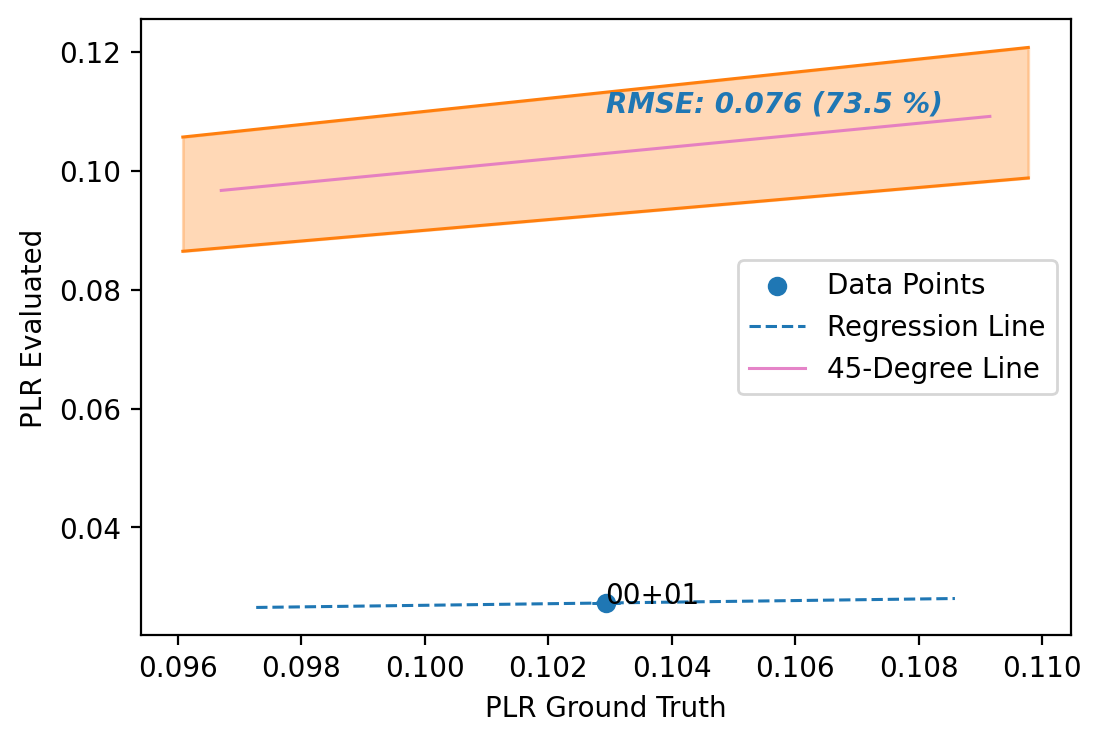

In [163]:
eval = DEval(filepaths, model_name='BR', model_suffix=suffix, sr_model_id=sr_model_id, dr_model_id=dr_model_id)
eval.run_hist_method(N=1)
eval.plot('BR')